In [1]:
import h5py
import os
import numpy as np

def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

file = h5py.File('processed_data.h5','r+') 

#Retrieves all the preprocessed training and validation\testing data from a file

X_train = file['X_train'][...]
Y_train = file['Y_train'][...]
X_test = file['X_test'][...]
Y_test = file['Y_test'][...]

# Unpickles and retrieves class names and other meta informations of the database
classes = unpickle('cifar-10-batches-py/batches.meta') #keyword for label = label_names

# The steps below are completely unncessary. A long time ago, I put some modified version of X_train and X_test 
# into the X_train_feed and X_test_feed variables but things changed since then (as in I discarded those modifications). 
# But even though things changedit was difficult to change back all variables X_train_feed and X_test_feed 
# that are used later on the code to X_train and X_test which is why I made these unnecessary steps to put X_train and X_test
# into X_train_feed and X_test_feed

X_train_feed = X_train
X_test_feed = X_test

print("Training sample shapes (input and output): "+str(X_train.shape)+" "+str(Y_train.shape))
print("Testing sample shapes (input and output): "+str(X_test.shape)+" "+str(Y_test.shape))


Training sample shapes (input and output): (50000, 32, 32, 3) (50000, 10)
Testing sample shapes (input and output): (10000, 32, 32, 3) (10000, 10)


In [2]:
# Creates nested list. The outer list will list all the classess (0-9). And each of the classes represent the inner list which list all
#training data that belongs to that class. I used list because it is easy to keep on adding dynamically. Ndarrays may have needed 
#a predifined shape

classes_num = len(classes['label_names']) #classes_num = no. of classes

# Here, I am creating a special variable X_train_F which is basically a nested list.
# The outermost list of X_train_F will be a list of all the class values (0-9 where each value correspond to a class name)
# Each elements (class values) of the outermost list is actually also a list; a list of all the example data belonging
# to the particular class which corresponds to class value under which the data is listed. 

X_train_F = []

for i in xrange(0,classes_num):
    X_train_F.append(str(i))
    X_train_F[i]=[]


for i in xrange(0,len(X_train)):
    l = int(np.argmax(Y_train[i])) #l for label (in this case it's basically the index of class value elemenmts)  
    #(Y_train is one hot encoded. Argmax returns the index for maximum value which should be 1 and
    # that index should indicate the value)
    X_train_F[l].append(X_train[i])
    

In [3]:
import matplotlib.pyplot as plt
from scipy.misc import toimage
from scipy.misc import imresize
%matplotlib inline

#function for showing pictures in grid along with labels

def picgrid(X_train,Y_train,gray=0):
    plt.figure(figsize=(7,7))
    ax=[]
    for i in xrange(0,25):
        img = toimage(X_train[i])
        ax.append(plt.subplot(5,5,i+1))
        ax[i].set_title( classes['label_names'][int(np.argmax(Y_train[i]))],y=-0.3)
        ax[i].set_axis_off()
        if gray==0:
            plt.imshow(img)
        else:
            plt.imshow(img,cmap='gray')
    plt.subplots_adjust(hspace=0.3)
    plt.axis('off')
    plt.show()

Sample arranged images in a batch: 


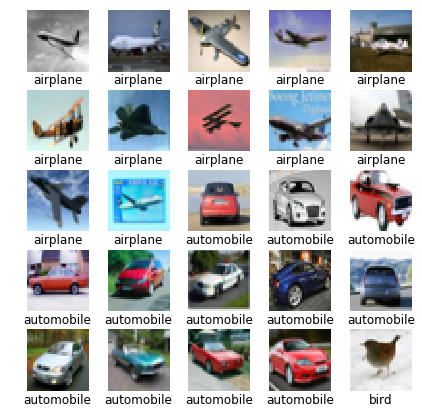

In [4]:
import random

def create_batch(batch_size,classes_num):
   
    s = int(batch_size/classes_num) #s denotes samples taken from each class to create the batch.
    l = np.zeros((classes_num))
    ran = []
    batch_Y = np.zeros((Y_train.shape))
    batch_X = np.zeros(((s*classes_num),32,32,3)) # s*classes_num = batch size reduced to the closest integer 
                                                  # divisible by classes_num if not divisble to begin with.

    for i in xrange(0,classes_num):
        l[i] = len(X_train_F[i])
        ran.append(random.sample(np.arange(1,l[i],1,'int'), s)) # Choose s no. of random samples from each class
        #print ran[i]
        for j in xrange(0,s):
            batch_X[(i*s)+j] = X_train_F[i][int(ran[i][j])] # Assign the s chosen random samples to the training batch
            batch_Y[(i*s)+j][i] = 1 # Creates one hot encoded batch of output samples
    
    return batch_X,batch_Y

batch_X,batch_Y = create_batch(120,classes_num) # A demo of the function at work

# Since each batch will have equal no. of cases from each class, no batch should be biased towards some particular classes

print "Sample arranged images in a batch: "
picgrid(batch_X,batch_Y)

Sample batch training images after light augmentation (50% chance of horizontal flips):


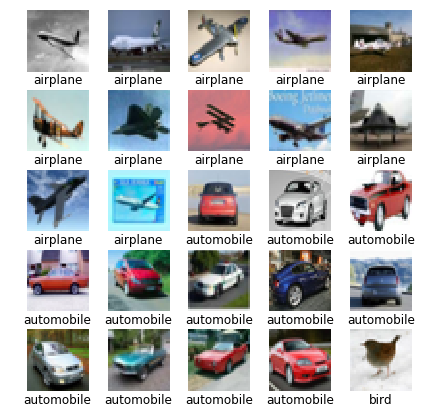

In [5]:
"""def random_crop(img):
    c = np.random.randint(0,5)
    if c==0:
        crop = img[8:32,0:-8]
    elif c==1:
        crop = img[0:-8,0:-8]
    elif c==2:
        crop = img[4:-4,4:-4]
    elif c==3:
        crop = img[8:32,8:32]
    elif c==4:
        crop = img[0:-8,8:32]
    return crop"""

def augment_batch(batch_X): #will be used to modify images realtime during training (real time data augmentation)
    
    aug_batch_X = np.zeros((len(batch_X),32,32,3))
   
    for i in xrange(0,len(batch_X)):
        
        hf = np.random.randint(0,2)
        
        if hf == 1: #hf denotes horizontal flip. 50-50 random chance to apply horizontal flip on images,
            batch_X[i] = np.fliplr(batch_X[i])
       
        # Remove the below cropping to apply random crops. But before that it's better to implement something like mirror padding
        # or any form of padding to increase the dimensions beforehand.
        
        """c = np.random.randint(0,5)
        if c==4:
           #crop randomly to 24x24
            aug_batch_X[i] = imresize(toimage(random_crop(batch_X[i])),(32,32))
        else:
            aug_batch_X[i] = batch_X[i]"""
    
    return batch_X
    
    
aug_batch_X = augment_batch(batch_X)

print "Sample batch training images after light augmentation (50% chance of horizontal flips):"
picgrid(aug_batch_X,batch_Y)

Sample batch training images after shuffling


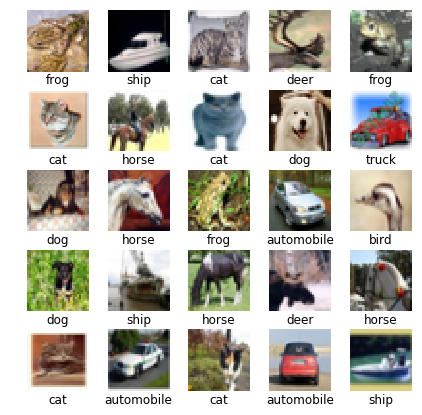

In [6]:
def shuffle_batch(batch_X,batch_Y):
    shuffle = random.sample(np.arange(0,len(batch_X),1,'int'),len(batch_X))
    shuffled_batch_X = []
    shuffled_batch_Y = []
    
    for i in xrange(0,len(batch_X)):
        shuffled_batch_X.append(batch_X[int(shuffle[i])])
        shuffled_batch_Y.append(batch_Y[int(shuffle[i])])
    
    shuffled_batch_X = np.array(shuffled_batch_X)
    shuffled_batch_Y = np.array(shuffled_batch_Y)

    return shuffled_batch_X,shuffled_batch_Y

s_batch_X, s_batch_Y = shuffle_batch(aug_batch_X,batch_Y)


print "Sample batch training images after shuffling"
picgrid(s_batch_X,s_batch_Y)

In [7]:
def batch(batch_size): #one shortcut function to execute all necessary functions to create a training batch
    batch_X,batch_Y = create_batch(batch_size,classes_num)
    aug_batch_X = augment_batch(batch_X)
    s_batch_X,s_batch_Y = shuffle_batch(aug_batch_X,batch_Y)
    return s_batch_X.reshape((len(batch_X),32,32,3)),s_batch_Y

In [8]:
import tensorflow as tf

FLAGS = tf.app.flags.FLAGS
# Basic model parameters.
tf.app.flags.DEFINE_boolean('use_fp16', False,
                            """Train the model using fp16.""")


In [9]:
#Hyper Parameters!

learning_rate = 0.01
batch_size = 120
training_iters = 200*(int(len(X_train)/batch_size))
layers = 16


# 1 conv + 3 convblocks*(3 conv layers *1 group for each block + 2 conv layers*(N-1) groups for each block [total 1+N-1 = N groups]) = layers
# 3*2*(N-1) = layers - 1 - 3*3
# N = (layers -10)/6 + 1

N = ((layers-10)/6)+1
K = 4 #(deepening factor)

#(N and K are used in the same sense as defined here: https://arxiv.org/abs/1605.07146)

n_classes = classes_num # another useless step that I made due to certain reasons. 

# tf Graph input

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.float32, [None, n_classes])

keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
phase = tf.placeholder(tf.bool, name='phase') 
# (Phase = true means training is undergoing. The contrary is ment when Phase is false.)

In [10]:
# Create some wrappers for simplicity

def conv2d(x,shape,strides):
    # Conv2D wrapper
    W = tf.Variable(tf.truncated_normal(shape=shape,stddev=5e-2))
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    # Didn't add bias because I read somewhere it's not necessary to add a bias if batch normalization is to be performed later
    # May be add L2 regularization or something here if you wish to.
    return x

def activate(x,phase):
    #wrapper for performing batch normalization and relu activation
    x = tf.contrib.layers.batch_norm(x, center=True, scale=True,variables_collections=["batch_norm_non_trainable_variables_collection"],updates_collections=None, decay=0.9,is_training=phase,zero_debias_moving_mean=True, fused=True)
    return tf.nn.relu(x,'relu')


def wideres33block(X,N,K,iw,bw,s,dropout,phase):
    
    # Creates N no. of 3,3 type residual blocks with dropout that consitute the conv2/3/4 blocks
    # with widening factor K and X as input. s is stride and bw is base width (no. of filters before multiplying with k)
    # iw is input width.
    # (see https://arxiv.org/abs/1605.07146 paper for details on the block)
    # In this case, dropout = probability to keep the neuron enabled.
    # phase = true when training, false otherwise.
    
    conv33_1 = conv2d(X,[3,3,iw,bw*K],s)
    conv33_1 = activate(conv33_1,phase)
    
    conv33_1 = tf.nn.dropout(conv33_1,dropout)
    
    conv33_2 = conv2d(conv33_1,[3,3,bw*K,bw*K],1)
    conv_s_1 = conv2d(X,[1,1,iw,bw*K],s) #shortcut connection
    
    caddtable = tf.add(conv33_2,conv_s_1)
    
    #1st of the N blocks for conv2/3/4 block ends here. The rest of N-1 blocks will be implemented next with a loop.

    for i in range(0,N-1):
        
        C = caddtable
        Cactivated = activate(C,phase)
        
        conv33_1 = conv2d(Cactivated,[3,3,bw*K,bw*K],1)
        conv33_1 = activate(conv33_1,phase)
        
        conv33_1 = tf.nn.dropout(conv33_1,dropout)
            
        conv33_2 = conv2d(conv33_1,[3,3,bw*K,bw*K],1)
        caddtable = tf.add(conv33_2,C)
    
    return activate(caddtable,phase)


    
def WRN(x, dropout, phase): #Wide residual network

    conv1 = conv2d(x,[3,3,3,16],1)
    conv1 = activate(conv1,phase)

    conv2 = wideres33block(conv1,N,K,16,16,1,dropout,phase)
    conv3 = wideres33block(conv2,N,K,16*K,32,2,dropout,phase)
    conv4 = wideres33block(conv3,N,K,32*K,64,2,dropout,phase)

    pooled = tf.nn.avg_pool(conv4,ksize=[1,8,8,1],strides=[1,1,1,1],padding='VALID')
    
    #Initialize weights and biases for fully connected layers
    wd1 = tf.Variable(tf.truncated_normal([1*1*64*K, 64*K],stddev=5e-2))
    bd1 = tf.Variable(tf.constant(0.1,shape=[64*K]))
    wout = tf.Variable(tf.random_normal([64*K, n_classes]))
    bout = tf.Variable(tf.constant(0.1,shape=[n_classes]))

    # Fully connected layer
    # Reshape pooling layer output to fit fully connected layer input
    
    fc1 = tf.reshape(pooled, [-1, wd1.get_shape().as_list()[0]])   
    fc1 = tf.add(tf.matmul(fc1, wd1), bd1)
    fc1 = tf.nn.relu(fc1)

    #fc1 = tf.nn.dropout(fc1, dropout) #Not sure if I should or should not apply dropout here.
    
    # Output, class prediction
    out = tf.add(tf.matmul(fc1, wout), bout)
    
    return out

In [11]:
# Construct model
model = WRN(x,keep_prob,phase)

# Define loss and optimizer

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))

global_step = tf.Variable(0)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum = 0.9, use_nesterov=True).minimize(cost,global_step=global_step)

#learning_rate = tf.train.exponential_decay(init_lr,global_step*batch_size, decay_steps=len(X_train), decay_rate=0.95, staircase=True)

# Evaluate model
correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
prediction = tf.nn.softmax(logits=model)

# Initializing the variables
init = tf.global_variables_initializer()

In [12]:

with tf.Session() as sess: # Start Tensorflow Session
    
    saver = tf.train.Saver() # Prepares variable for saving the model
    sess.run(init) #initialize all variables
    step = 1   
    loss_list=[]
    acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    best_val_acc=0
    total_loss=0
    total_acc=0
    display_step=int(len(X_train)/batch_size) 
    # (Interval after which average training accuracy and validation accuracy is displayed)
    
    bit_too_many_iterations = 100000 # Maximum iterations that shouldn't be surpassed in any circumstances 
    
    max_patience = 5  # No. of consecutive iterations for which the program will endure 
                      # the best validation accuracy not being surpassed
                      # if the minimum acceptable accuracy is reached
    
    patience = 0 # No. of consecutive iterations for which the best validation accuracy is not surpassed

    flag = 0
    
    min_acceptable_acc = 0.9 # (min_acceptable_acc*100)% = Minimum Acceptable Accuracy in Percentage
                             # If minimum acceptable accuracy is not reached at the end of iterations,
                             # iterations will be increased as long as it's <= bit_too_many_iterations.
    
    while step <= training_iters:
        
        batch_x, batch_y = batch(batch_size)
        
        # A very basic implementation of learning rate scheduling. 
        if step == 100*(int(len(X_train)/batch_size)):
            print "\nDecreasing Learning Rate to 0.001"
            learning_rate = 0.001
 
        # Run optimization operation (backpropagation)
        _,loss,acc = sess.run([optimizer,cost,accuracy],feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7, phase: True})
        
        total_loss += loss
        total_acc += acc
                
        if step%100 == 0:
            print "Iter " + str(step) + ", Minibatch Loss= " + \
                  "{:.3f}".format(loss) + ", Minibatch Accuracy= " + \
                  "{:.3f}%".format(acc*100)

        if step % display_step == 0:
                      
            total_val_loss=0
            total_val_acc=0
            val_loss=0
            val_acc=0
            avg_val_loss=0
            avg_val_acc=0
            
            for i in xrange(0,len(X_test_feed)):
                val_loss, val_acc = sess.run([cost, accuracy], feed_dict={x: X_test_feed[i].reshape((1,32,32,3)),
                                                                      y: Y_test[i].reshape((1,n_classes)),
                                                                      keep_prob: 1,
                                                                      phase: False})

                total_val_loss= total_val_loss+val_loss
                total_val_acc = total_val_acc+val_acc
                
            avg_val_loss = total_val_loss/len(X_test_feed) # Average validation loss
            avg_val_acc = total_val_acc/len(X_test_feed) # Average validation accuracy
             
            val_loss_list.append(avg_val_loss) # Storing values in list for plotting later on.
            val_acc_list.append(avg_val_acc) # Storing values in list for plotting later on.
            
            avg_loss = total_loss/int(display_step) # Average mini-batch training loss
            avg_acc = total_acc/int(display_step)  # Average mini-batch training accuracy
            
            loss_list.append(avg_loss) # Storing values in list for plotting later on.
            acc_list.append(avg_acc) # Storing values in list for plotting later on.
            
            total_loss=0
            total_acc=0

            print "\nIter " + str(step) + ", Validation Loss= " + \
                    "{:.3f}".format(avg_val_loss) + ", validation Accuracy= " + \
                    "{:.3f}%".format(avg_val_acc*100)+""
            print "Iter " + str(step) + ", Average Training Loss= " + \
                    "{:.3f}".format(avg_loss) + ", Average Training Accuracy= " + \
                    "{:.3f}%".format(avg_acc*100)+""
                    
            if avg_val_acc > best_val_acc: # When better accuracy is received than previous best validation accuracy
                
                best_val_acc = avg_val_acc # update value of best validation accuracy received yet.
                saver.save(sess, 'Model_Backup/model.ckpt') # save_model including model variables (weights, biases etc.)
                print "Checkpoint created!"
                patience = 0 # Reset patience value 
                
            else:
                patience += 1 
                
            if patience >= max_patience and best_val_acc >= min_acceptable_acc:
                flag = 1
                
                
            print ""
            
            if best_val_acc < min_acceptable_acc and step <= bit_too_many_iterations and step == training_iters:
                print "\nAdding iterations since minimum acceptable accuracy is not achieved!\n"
                training_iters += 1000
            
            
        if flag == 1:
            print "\nStopping early since accuracy not increasing!\n"
            break
            
        step += 1
        
    print "\nOptimization Finished!\n"
    
    print "Best Test Accuracy: %.3f%%"%((best_val_acc)*100)
     
    

Iter 100, Minibatch Loss= 2.144, Minibatch Accuracy= 23.333%
Iter 200, Minibatch Loss= 1.980, Minibatch Accuracy= 24.167%
Iter 300, Minibatch Loss= 1.756, Minibatch Accuracy= 34.167%
Iter 400, Minibatch Loss= 1.606, Minibatch Accuracy= 45.833%

Iter 416, Validation Loss= 1.646, validation Accuracy= 39.490%
Iter 416, Average Training Loss= 2.404, Average Training Accuracy= 26.997%
Checkpoint created!

Iter 500, Minibatch Loss= 1.601, Minibatch Accuracy= 43.333%
Iter 600, Minibatch Loss= 1.663, Minibatch Accuracy= 40.833%
Iter 700, Minibatch Loss= 1.346, Minibatch Accuracy= 52.500%
Iter 800, Minibatch Loss= 1.654, Minibatch Accuracy= 39.167%

Iter 832, Validation Loss= 1.494, validation Accuracy= 47.530%
Iter 832, Average Training Loss= 1.518, Average Training Accuracy= 44.233%
Checkpoint created!

Iter 900, Minibatch Loss= 1.324, Minibatch Accuracy= 51.667%
Iter 1000, Minibatch Loss= 1.361, Minibatch Accuracy= 47.500%
Iter 1100, Minibatch Loss= 1.109, Minibatch Accuracy= 57.500%
Iter 12

Checkpoint created!

Iter 8400, Minibatch Loss= 0.358, Minibatch Accuracy= 86.667%
Iter 8500, Minibatch Loss= 0.530, Minibatch Accuracy= 81.667%
Iter 8600, Minibatch Loss= 0.373, Minibatch Accuracy= 86.667%
Iter 8700, Minibatch Loss= 0.473, Minibatch Accuracy= 84.167%

Iter 8736, Validation Loss= 0.513, validation Accuracy= 82.850%
Iter 8736, Average Training Loss= 0.424, Average Training Accuracy= 85.248%
Checkpoint created!

Iter 8800, Minibatch Loss= 0.360, Minibatch Accuracy= 84.167%
Iter 8900, Minibatch Loss= 0.380, Minibatch Accuracy= 86.667%
Iter 9000, Minibatch Loss= 0.427, Minibatch Accuracy= 84.167%
Iter 9100, Minibatch Loss= 0.414, Minibatch Accuracy= 86.667%

Iter 9152, Validation Loss= 0.509, validation Accuracy= 83.130%
Iter 9152, Average Training Loss= 0.408, Average Training Accuracy= 85.701%
Checkpoint created!

Iter 9200, Minibatch Loss= 0.346, Minibatch Accuracy= 87.500%
Iter 9300, Minibatch Loss= 0.403, Minibatch Accuracy= 85.000%
Iter 9400, Minibatch Loss= 0.451, M


Iter 16640, Validation Loss= 0.385, validation Accuracy= 87.580%
Iter 16640, Average Training Loss= 0.230, Average Training Accuracy= 91.929%
Checkpoint created!

Iter 16700, Minibatch Loss= 0.199, Minibatch Accuracy= 92.500%
Iter 16800, Minibatch Loss= 0.370, Minibatch Accuracy= 90.833%
Iter 16900, Minibatch Loss= 0.161, Minibatch Accuracy= 93.333%
Iter 17000, Minibatch Loss= 0.174, Minibatch Accuracy= 93.333%

Iter 17056, Validation Loss= 0.402, validation Accuracy= 87.760%
Iter 17056, Average Training Loss= 0.220, Average Training Accuracy= 92.218%
Checkpoint created!

Iter 17100, Minibatch Loss= 0.267, Minibatch Accuracy= 91.667%
Iter 17200, Minibatch Loss= 0.276, Minibatch Accuracy= 93.333%
Iter 17300, Minibatch Loss= 0.256, Minibatch Accuracy= 90.000%
Iter 17400, Minibatch Loss= 0.232, Minibatch Accuracy= 92.500%

Iter 17472, Validation Loss= 0.406, validation Accuracy= 87.290%
Iter 17472, Average Training Loss= 0.219, Average Training Accuracy= 92.302%

Iter 17500, Minibatch Lo

Iter 24900, Minibatch Loss= 0.065, Minibatch Accuracy= 98.333%

Iter 24960, Validation Loss= 0.396, validation Accuracy= 88.620%
Iter 24960, Average Training Loss= 0.129, Average Training Accuracy= 95.343%
Checkpoint created!

Iter 25000, Minibatch Loss= 0.118, Minibatch Accuracy= 95.833%
Iter 25100, Minibatch Loss= 0.067, Minibatch Accuracy= 99.167%
Iter 25200, Minibatch Loss= 0.100, Minibatch Accuracy= 96.667%
Iter 25300, Minibatch Loss= 0.121, Minibatch Accuracy= 95.833%

Iter 25376, Validation Loss= 0.407, validation Accuracy= 88.760%
Iter 25376, Average Training Loss= 0.123, Average Training Accuracy= 95.459%
Checkpoint created!

Iter 25400, Minibatch Loss= 0.094, Minibatch Accuracy= 96.667%
Iter 25500, Minibatch Loss= 0.187, Minibatch Accuracy= 93.333%
Iter 25600, Minibatch Loss= 0.160, Minibatch Accuracy= 92.500%
Iter 25700, Minibatch Loss= 0.131, Minibatch Accuracy= 95.000%

Iter 25792, Validation Loss= 0.395, validation Accuracy= 88.960%
Iter 25792, Average Training Loss= 0.11

Iter 33200, Minibatch Loss= 0.048, Minibatch Accuracy= 98.333%

Iter 33280, Validation Loss= 0.419, validation Accuracy= 89.470%
Iter 33280, Average Training Loss= 0.075, Average Training Accuracy= 97.324%

Iter 33300, Minibatch Loss= 0.075, Minibatch Accuracy= 99.167%
Iter 33400, Minibatch Loss= 0.107, Minibatch Accuracy= 96.667%
Iter 33500, Minibatch Loss= 0.050, Minibatch Accuracy= 98.333%
Iter 33600, Minibatch Loss= 0.106, Minibatch Accuracy= 95.833%

Iter 33696, Validation Loss= 0.469, validation Accuracy= 88.800%
Iter 33696, Average Training Loss= 0.070, Average Training Accuracy= 97.530%

Iter 33700, Minibatch Loss= 0.098, Minibatch Accuracy= 97.500%
Iter 33800, Minibatch Loss= 0.076, Minibatch Accuracy= 97.500%
Iter 33900, Minibatch Loss= 0.028, Minibatch Accuracy= 99.167%
Iter 34000, Minibatch Loss= 0.063, Minibatch Accuracy= 97.500%
Iter 34100, Minibatch Loss= 0.077, Minibatch Accuracy= 96.667%

Iter 34112, Validation Loss= 0.415, validation Accuracy= 89.540%
Iter 34112, Aver


Decreasing Learning Rate to 0.001
Iter 41600, Minibatch Loss= 0.064, Minibatch Accuracy= 97.500%

Iter 41600, Validation Loss= 0.450, validation Accuracy= 89.810%
Iter 41600, Average Training Loss= 0.047, Average Training Accuracy= 98.269%
Checkpoint created!

Iter 41700, Minibatch Loss= 0.060, Minibatch Accuracy= 96.667%
Iter 41800, Minibatch Loss= 0.073, Minibatch Accuracy= 98.333%
Iter 41900, Minibatch Loss= 0.019, Minibatch Accuracy= 99.167%
Iter 42000, Minibatch Loss= 0.032, Minibatch Accuracy= 98.333%

Iter 42016, Validation Loss= 0.441, validation Accuracy= 89.620%
Iter 42016, Average Training Loss= 0.047, Average Training Accuracy= 98.247%

Iter 42100, Minibatch Loss= 0.063, Minibatch Accuracy= 97.500%
Iter 42200, Minibatch Loss= 0.053, Minibatch Accuracy= 99.167%
Iter 42300, Minibatch Loss= 0.102, Minibatch Accuracy= 97.500%
Iter 42400, Minibatch Loss= 0.027, Minibatch Accuracy= 99.167%

Iter 42432, Validation Loss= 0.437, validation Accuracy= 89.910%
Iter 42432, Average Trai

In [13]:
#Saving logs about change of training and validation loss and accuracy over epochs in another file.

import h5py

file = h5py.File('Training_logs.h5','w')
file.create_dataset('val_acc', data=np.array(val_acc_list))
file.create_dataset('val_loss', data=np.array(val_loss_list))
file.create_dataset('acc', data=np.array(acc_list))
file.create_dataset('loss', data=np.array(loss_list))

file.close()

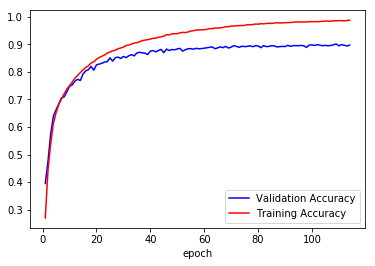

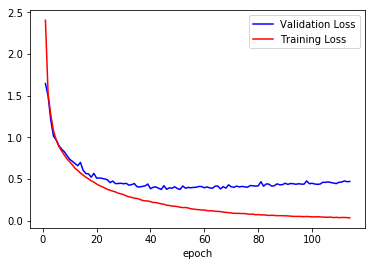

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

log = h5py.File('Training_logs.h5','r+') # Loading logs about change of training and validation loss and accuracy over epochs

y1 = log['val_acc'][...]
y2 = log['acc'][...]

x = np.arange(1,len(y1)+1,1) # (1 = starting epoch, len(y1) = no. of epochs, 1 = step) 

plt.plot(x,y1,'b',label='Validation Accuracy') 
plt.plot(x,y2,'r',label='Training Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.show()

y1 = log['val_loss'][...]
y2 = log['loss'][...]

plt.plot(x,y1,'b',label='Validation Loss')
plt.plot(x,y2,'r',label='Training Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.show()